In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from random import random
import scipy.stats
#import corner
from mpl_toolkits import mplot3d

plt.style.use('seaborn-whitegrid')

np.random.seed(2) #Número aleatorio para que los procesos se asimilen.

In [2]:
v = np.load('fit_ejercise.npy')

In [3]:
#Ecuación de la recta en 3D
def recta(x, a, b):
    return a * x + b

#La función del logaritmo del likelihood:
def chisq(parametros, data):
    x = data[0]
    y = data[1]
    y_err = data[2]
    
    model = recta(x, parametros[0], parametros[1])
    chisq = (y - model) ** 2 / y_err ** 2
    return chisq.sum()

In [4]:
#Número de iteraciones por cada camino:
N = 500
#Número de caminos (j):
caminos = 5
#Desviación estándar para determinar a, b iniciales:
sigma = 0.2
#Arreglos en los que se guardarán los valores iniciales de a, b, lh (igual al número de caminos):
a_inicial = []
b_inicial = []
lh_inicial = []

#Valor inicial de parámetros (a, b, lh):
for i in range(caminos):
    a_inicial.append(np.random.normal(-1 + (((-1) ** i) * i), sigma))
    b_inicial.append(np.random.normal(4 + (((-1) ** i) * i), sigma))
    #Valor inicial del likelihood:
    lh_inicial.append(chisq([a_inicial[i], b_inicial[i]], [v[0], v[1], v[2]]))

#Arreglos donde se guardarán los valores de a, b, likelihood (resultado):
a = []
b = []
lh = []

#Se guardan los primeros valores propuestos:
for i in range(caminos):
    a.append([a_inicial[i]])
    b.append([b_inicial[i]])
    lh.append([lh_inicial[i]])

In [5]:
#Contador para guardar en lugar indicado resutado para arreglos a, b, lh:
k = 0
#Razón de aceptación para cada uno de los caminos:
acep = []

#El algoritmo se repite para cada camino:
for j in range(caminos):
    #Para cada camino, se agrega una posición de razón de aceptación:
    acep.append(0)
    for i in range(N - 1):
        #Se generan dos valores random, no importa la distribución en rango [0,10].
        a_aux = np.random.normal(a[j][k], sigma)
        b_aux = np.random.normal(b[j][k], sigma)
        #Valor con el que se producirá la primer comparación para actualización de likelihood.
        lh_aux = chisq([a_aux, b_aux], [v[0], v[1], v[2]])
        #Condición de likelihood:
        if lh_aux < lh_inicial[j]:
            #Si se cumple la condición, se agregan a, b y se actualiza el valor del likelihood.
            a[j].append(a_aux)
            b[j].append(b_aux)
            lh[j].append(lh_aux)
            lh_inicial[j] = lh_aux
            k += 1
            acep[j] += 1
        else:
            #Si no, hay una segunda oportunidad para aceptar el valor:
            comparador = - np.log(np.random.uniform(0,1))
            #Si se cumple que la resta sea menor al comparador (segunda oportunidad):
            if (lh_aux - lh_inicial[j]) < comparador:
                a[j].append(a_aux)
                b[j].append(b_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux
                k += 1
                acep[j] += 1
            #Si no, se agrega valor anterior de a, b y se añade valor de lh:
            else:
                a[j].append(a[j][i - 1])
                b[j].append(b[j][i - 1])
                lh[j].append(lh_inicial[j])
                k += 1
    k = 0

#---------Aceptación---------#
for i in range(caminos):
    acep[i] /= N
acep

[0.024, 0.062, 0.044, 0.112, 0.066]

In [6]:
#El mínimo chi square está en:
parametros = []
for i in range(caminos):
    parametros.append(np.where(lh[i] == np.min(lh[i])))

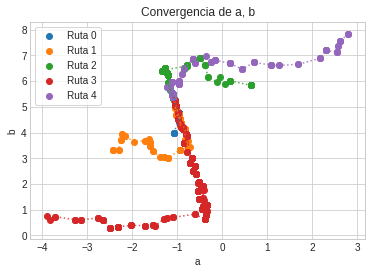

In [7]:
plt.title('Convergencia de a, b')
for i in range(caminos):
    plt.scatter(a[i], b[i], label = 'Ruta {0}'.format(i))
    plt.plot(a[i], b[i], linestyle = ':', alpha = 0.8)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.legend(frameon = True)
plt.show()

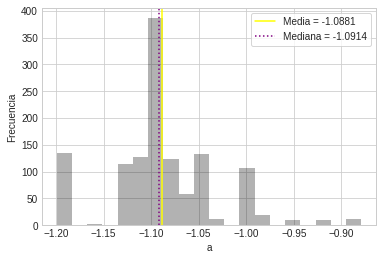

In [8]:
a_total = []

for i in range(caminos):
    for j in range(np.int(len(a[i]) / 2), len(a[i])):
        a_total.append(a[i][j])
plt.hist(a_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(a_0, color = 'red', label = 'Real = {0}'.format(a_0))
plt.axvline(np.mean(a_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(a_total), 4)))
plt.axvline(np.median(a_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(a_total), 4)))
plt.xlabel('a')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

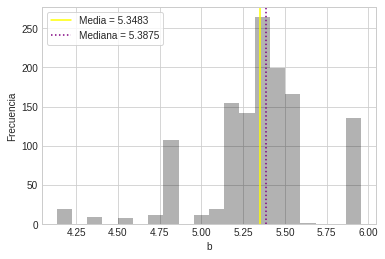

In [9]:
b_total = []

for i in range(caminos):
    for j in range(np.int(len(b[i]) / 2), len(b[i])):
        b_total.append(b[i][j])
plt.hist(b_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
plt.axvline(np.mean(b_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(b_total), 4)))
plt.axvline(np.median(b_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(b_total), 4)))
plt.xlabel('b')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

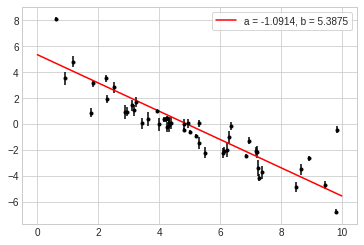

In [10]:
x = np.linspace(0, 10, 100)
plt.errorbar(v[0], v[1], yerr = v[2], fmt='.', color = 'black')
plt.plot(x, recta(x, np.mean(a_total), np.mean(b_total)), color = 'red', label = 'a = {0}, b = {1}'.format(np.round(np.median(a_total), 4), np.round(np.median(b_total), 4)))
plt.legend(frameon = True)
plt.show()

Ahora en lugar de <strong>sigma</strong> como error en la función <strong>chisq,</strong> se cambia a <strong>delta.</strong> En esta sección se añade un nuevo parámetro.

In [21]:
#Nueva definición de log_likelihood, parametros[2] será el nuevo parámetro libre (log_f):
def chisq_n(parametros, v):
    #m, b, log_f = parametros
    x, y, y_err = v[0], v[1], v[2]
    model = recta(x, parametros[0], parametros[1])
    sigma2 = y_err ** 2 + model ** 2 * (parametros[2] ** 2)
    return 0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#El prior que se define a continuación como uniforme (también conocido como no informativo):
def prior(parametros):
    #Sabemos que m < 0, b > 0, desconocemos a log_f:
    if -10.0 < parametros[0] < 0.0 and 0.0 < parametros[1] < 10.0 and -10.0 < parametros[2] < 10.0:
        #Peso estadístico aleatorio (sugerido en clase):
        return 0.0
    return - np.inf

In [41]:
N = 10000
caminos = 5
sigma = 0.2
a_inicial = []
b_inicial = []
f_inicial = []
lh_inicial = []

#Valor inicial de parámetros:
for i in range(caminos):
    a_inicial.append(np.random.normal(-1, sigma))
    b_inicial.append(np.random.normal(4, sigma))
    f_inicial.append(np.random.normal(1, sigma))
    #Valor inicial del likelihood:
    lh_inicial.append(chisq_n([a_inicial[i], b_inicial[i], f_inicial[i]], [v[0], v[1], v[2]]))

#Arreglos donde se guardarán los valores de a, b, likelihood:
#a = [range(N) for i in range(caminos)]
a = []
b = []
f = []
lh = []

#Se guardan los primeros valores propuestos:
for i in range(caminos):
    a.append([a_inicial[i]])
    b.append([b_inicial[i]])
    f.append([f_inicial[i]])
    lh.append([lh_inicial[i]])

In [42]:
k = 0
acep = []

for j in range(caminos):
    acep.append(0)
    for i in range(N):
        a_aux = np.random.normal(a[j][k], sigma)#Se generan dos valores random, no importa la distribución en rango [0,10].
        b_aux = np.random.normal(b[j][k], sigma)
        f_aux = np.random.normal(f[j][k], sigma)
        #En esta parte sí se considera el peso estadístico; prior:
        lh_aux = chisq_n([a_aux, b_aux, f_aux], [v[0], v[1], v[2]])
        if lh_aux < lh_inicial[j]:
            a[j].append(a_aux)
            b[j].append(b_aux)
            f[j].append(f_aux)
            lh[j].append(lh_aux)
            lh_inicial[j] = lh_aux
            k += 1
            acep[j] += 1
        else:
            comparador = -np.log(np.random.uniform(0,1)) 
            if (lh_aux - lh_inicial[j]) < comparador:
                a[j].append(a_aux)
                b[j].append(b_aux)
                f[j].append(f_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux
                k += 1
                acep[j] += 1
            else:
                a[j].append(a[j][i - 1])
                b[j].append(b[j][i - 1])
                f[j].append(f[j][i - 1])
                lh[j].append(lh_inicial[j])
                k += 1
                
    k = 0
    
#---------Aceptación---------#
for i in range(caminos):
    acep[i] /= N
acep

[0.0332, 0.0325, 0.0304, 0.0331, 0.0319]

In [43]:
#El mínimo chi square está en:
parametros = []
for i in range(caminos):
    parametros.append(np.where(lh[i] == np.min(lh[i])))

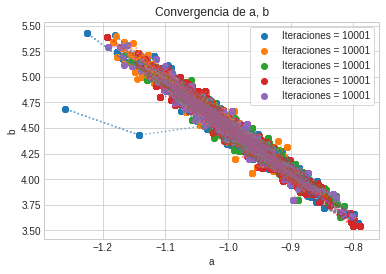

In [44]:
plt.title('Convergencia de a, b')
for i in range(caminos):
    plt.scatter(a[i], b[i], label = 'Iteraciones = {0}'.format(len(a[i])))
    plt.plot(a[i], b[i], linestyle = ':', alpha = 0.6)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.legend(frameon = True)
plt.show()

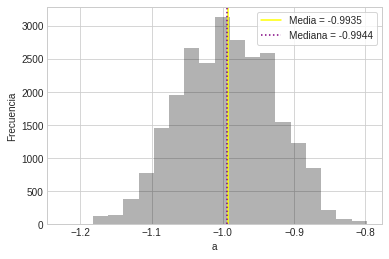

In [47]:
a_total = []

for i in range(caminos):
    for j in range(np.int(len(a[i]) / 2), len(a[i])):
        a_total.append(a[i][j])
plt.hist(a_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(a_0, color = 'red', label = 'Real = {0}'.format(a_0))
plt.axvline(np.mean(a_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(a_total), 4)))
plt.axvline(np.median(a_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(a_total), 4)))
plt.xlabel('a')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

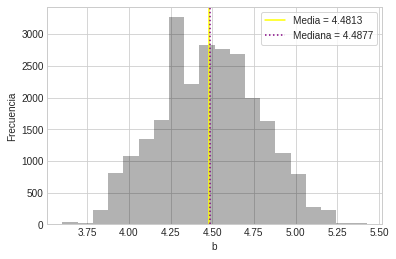

In [48]:
b_total = []

for i in range(caminos):
    for j in range(np.int(len(b[i]) / 2), len(b[i])):
        b_total.append(b[i][j])
plt.hist(b_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
plt.axvline(np.mean(b_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(b_total), 4)))
plt.axvline(np.median(b_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(b_total), 4)))
plt.xlabel('b')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

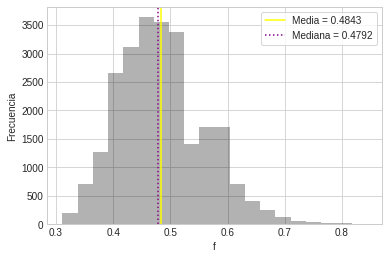

In [49]:
f_total = []

for i in range(caminos):
    for j in range(np.int(len(f[i]) / 2), len(f[i])):
        f_total.append(f[i][j])
plt.hist(f_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
plt.axvline(np.mean(f_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(f_total), 4)))
plt.axvline(np.median(f_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(f_total), 4)))
plt.xlabel('f')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

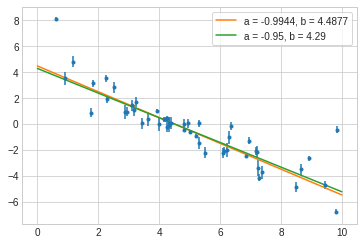

In [51]:
x = np.linspace(0, 10, 100)
plt.errorbar(v[0], v[1], yerr = v[2], fmt='.')
plt.plot(x, recta(x, np.mean(a_total), np.mean(b_total)), label = 'a = {0}, b = {1}'.format(np.round(np.median(a_total), 4), np.round(np.median(b_total), 4)))
plt.plot(x, recta(x, -0.95, 4.29), label = 'a = -0.95, b = 4.29')
plt.legend(frameon = True)
plt.show()

### <strong>Método de Gelman-Rubin</strong>

In [53]:
#----------MEDIA----------#
#Aquí se determinan las medias para cada cadena.
mean_an, mean_bn = [], []
for i in range(caminos):
    mean_an.append(np.sum(a[i]) / N)
    mean_bn.append(np.sum(b[i]) / N)
#Media de las medias de las cadenas:
mean_a, mean_b = np.sum(mean_an) / caminos, np.sum(mean_bn) / caminos

#----------VARIANZA----------#
var_an, var_bn = [], []
for i in range(caminos):
    var_an.append(np.var(a[i]))
    var_bn.append(np.var(b[i]))
var_a, var_b = np.var(var_an), np.var(var_bn)

#----------B----------#
B_a, B_b = 0, 0
for i in range(caminos):
    B_a += (mean_an[i] - mean_a) ** 2
    B_b += (mean_bn[i] - mean_b) ** 2
B_a, B_b = B_a / (caminos - 1), B_b / (caminos - 1)

#----------Sigma hat----------#
sig_a, sig_b = (((N - 1) * var_a) / N) + B_a, (((N - 1) * var_b) / N) + B_b

#----------R----------#
R_a, R_b = np.sqrt(sig_a / var_a), np.sqrt(sig_b / var_b)

R_a, R_b

(25.571372253738286, 5.715547922514445)